## Objective: To create a document term matrix for supervised learning from patent database

### Dataset from Thompson Reuters provided by Limagrain

#### Step 1: Install and load the required packages

In [32]:
library(solr)
library(httr)
library(jsonlite)
library(tm)
library(tidytext)
library(wordcloud)

setwd("/home/anandgavai/AARestructure/ODEX4all-UseCases/Limagrain/src")

patList<-read.csv("../data/excel2016-06-21-10-09-28.csv",header = TRUE)

Loading required package: RColorBrewer


#### Step 2a: Load files to create dictionary

In [2]:

dic_key<- read.csv("../data/keywords.csv",header=FALSE)
dic_key<-as.character(dic_key[,1])


##### remove leading and training white spaces

In [3]:
dic_key<-trimws(dic_key)

##### remove all special characters and replace them with space

In [4]:
dic_key <- gsub("[[:punct:]]", " ", dic_key)

##### remove \x96 from the character vector

In [5]:
dic_key <- gsub("\\\x96"," ",dic_key)

##### remove \x92 from the character vector

In [6]:
dic_key <- gsub("\\\x92"," ",dic_key)

##### remove \xd7 from the character vector

In [7]:
dic_key <- gsub("\\\xd7"," ",dic_key)


##### make dictionary of crop ontologies

In [8]:
dic_CO<-read.csv("CO_322.csv",header=TRUE)
dic_CO<-c(as.character(dic_CO$Trait.name),as.character(dic_CO$Attribute))

##### select only unique terms


In [11]:
dic_CO<-unique(dic_CO)


##### Combined dictionary keywords + CO terms 

In [12]:
dic_CO_Key<-c(dic_key,dic_CO)

##### Create dictionary from title terms DWPI


In [13]:
title<-as.character(patList$Title...DWPI)
ll<-NULL
for(i in 1:length(title)){
  ll<-c(ll,unlist(strsplit(title[i]," ")))   
}

##### Combined dictionary keywords + CO terms + Title terms

In [14]:
dic_CO_key_title<-c(dic_CO_Key,ll)
dic_CO_key_title<-unique(gsub(",","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub(";","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("\\(e.g.","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("e.g.","",dic_CO_key_title))


#### Step 3: Create corpus here.

In [15]:
abst_dwpi<- as.character(patList$Abstract...DWPI)

In [16]:
dfCorpus_abst_dwpi = Corpus(VectorSource(abst_dwpi)) 


#### Step 4: Data Transformation



##### Eliminating extra white spaces

In [17]:
reuters_abst_dwpi<-tm_map(dfCorpus_abst_dwpi,stripWhitespace)


##### Stem the documents


In [19]:
reuters_abst_dwpi<-tm_map(reuters_abst_dwpi,stemDocument)


##### convert to lower case


In [20]:
reuters_abst_dwpi <- tm_map(reuters_abst_dwpi, content_transformer(tolower))


##### remove stopwords


In [21]:
reuters_abst_dwpi <- tm_map(reuters_abst_dwpi, removeWords, stopwords("english"))


##### remove user defined words


In [23]:
reuters_abst_dwpi <- tm_map(reuters_abst_dwpi, removeWords, c("within","without"))


##### remove punctuation


In [24]:
reuters_abst_dwpi <- tm_map(reuters_abst_dwpi, removePunctuation)

##### remove numbers


In [25]:
reuters_abst_dwpi <- tm_map(reuters_abst_dwpi, removeNumbers)


#### Step 4: Create a document term matrix with (keywords, CO terms, title terms combined together)


In [26]:
dtm_abst_dwpi_CO_Key_Title <- DocumentTermMatrix(reuters_abst_dwpi,list(dictionary=dic_CO_key_title))


##### remove terms that occure in only 0.1% of all documents (in short less common words)


In [27]:
dt_abst_dwpi_CO_Key_Title<-removeSparseTerms(dtm_abst_dwpi_CO_Key_Title, 0.99) # this is tunable 0.6 appears to be optimal


In [28]:
row.names(dt_abst_dwpi_CO_Key_Title)<-patList$Publication.Number


##### create term frequency


In [29]:
termFreq <- colSums(as.matrix(dt_abst_dwpi_CO_Key_Title))


In [34]:
head(termFreq)
tf <- data.frame(term = names(termFreq), freq = termFreq)
tf <- tf[order(-tf[,2]),]
head(tf)


ability    absent    accept accession      acid     acids 
        4         5         5         7      1830        14

,term,freq
plant,plant,7338
least,least,2823
one,one,2583
marker,marker,2252
corn,corn,2025
select,select,1891


#### Step 5: Visualize word cloud of terms

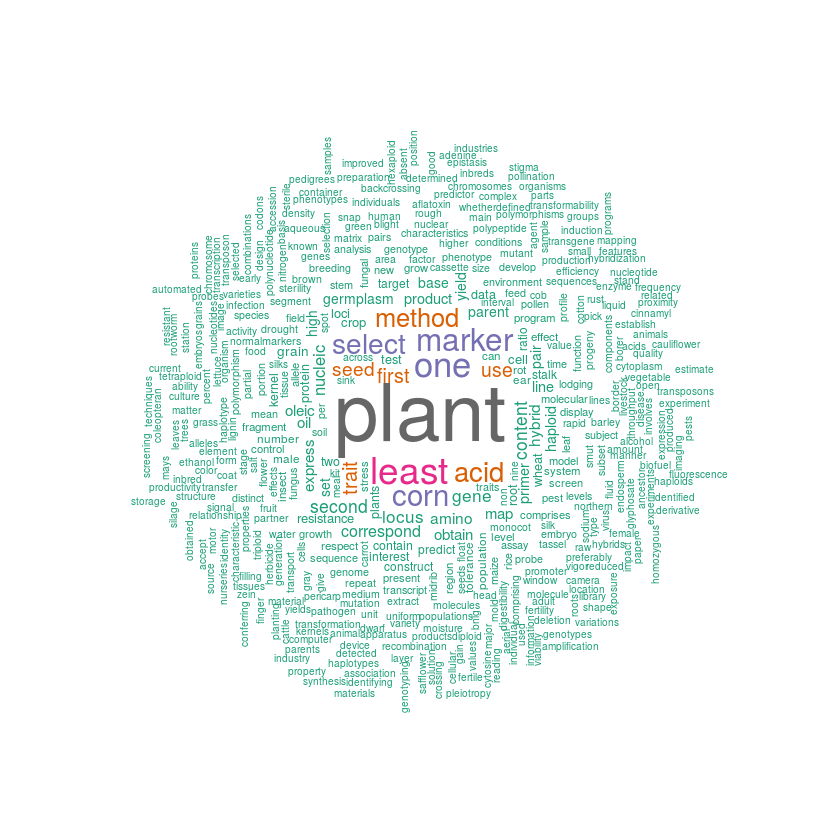

In [35]:
set.seed(1234)
wordcloud(words = tf$term, freq = tf$freq, min.freq = 1,
          max.words=8000, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))


#### Step 6 : Explore frequent terms and their associations


##### frequent terms

In [36]:
findFreqTerms(dt_abst_dwpi_CO_Key_Title, lowfreq = 500)

[1] "acid"       "amino"      "content"    "corn"       "correspond"
 [6] "express"    "first"      "gene"       "hybrid"     "least"     
[11] "locus"      "map"        "marker"     "method"     "nucleic"   
[16] "obtain"     "oil"        "oleic"      "one"        "plant"     
[21] "second"     "seed"       "select"     "trait"      "use"

##### frequent associations

In [38]:
findAssocs(dt_abst_dwpi_CO_Key_Title, terms = "trait", corlimit = 0.3)


$trait
           data      chromosome        distinct        breeding          select 
           0.52            0.49            0.49            0.48            0.48 
          fruit   polymorphisms          traits    polymorphism      properties 
           0.43            0.42            0.41            0.39            0.38 
        reading      resistance characteristics         library          method 
           0.38            0.38            0.37            0.36            0.36 
         window          medium        interest             map          plants 
           0.36            0.35            0.34            0.34            0.34 
           line      population           least           model         segment 
           0.33            0.33            0.32            0.32            0.32 
            set         nucleic             two          across       selection 
           0.32            0.31            0.31            0.30            0.30

##### Plot word frequency for first 10 terms

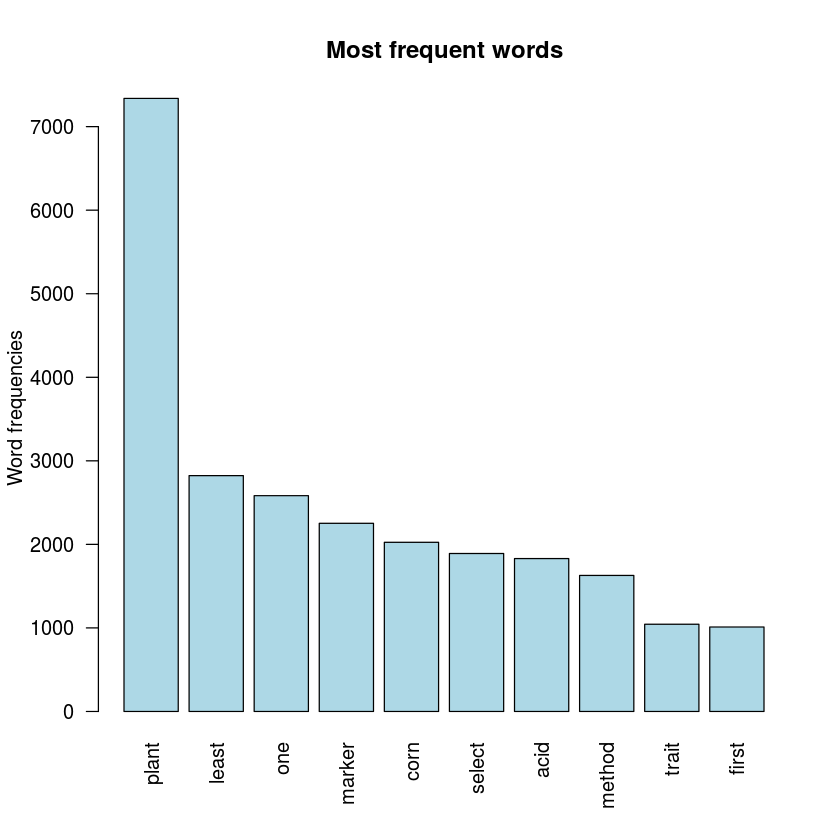

In [41]:
d<-barplot(tf[1:10,]$freq, las = 2, names.arg = tf[1:10,]$term,
           col ="lightblue", main ="Most frequent words",
           ylab = "Word frequencies")